--- 
description: Here we show how to solve graph coloring problems using JijZept and JijModeling.
---

# Graph Coloring Problem

Here we show how to solve graph coloring problems using JijZept and JijModeling. 
This problem is also mentioned in 6.1. Graph Coloring on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is the graph coloring problem?

In this problem, we color different colors to the two vertices on the same edge in a given graph.
This problem is related to the famous four-color theorem which we can color the map with four colors.
The picture below is a schematic picture of this theorem.
We can color every object in the figures with four colors.

![](./assets/graph_coloring_four_color.png)

If we can use only 3 colors, which is called 3-coloring, this is one of the famous NP-complete problems.

### Example

Let's consider the following undirected graph consisting of 6 vertices below as an example.

![](./assets/graph_coloring_01.png)

We can color this graph in three colors as follows.

![](./assets/graph_coloring_02.png)

No edge connects two vertices of the same color exist.

### Generalization

Next, we generalize the above example and express it in a mathematical model.
We consider coloring an undirected graph $G=(V, E)$ with $N$ colors and introduce variables $x_{v, n}$ which are 1 if vertex $v$ is colored with $n$ and 0 otherwise.

**Constraint: the vertices must be painted with one color**

This problem can not allow us to color a vertex with two colors.

$$
\sum_{n=0}^{N-1} x_{v, n} 
= 1 \quad (\forall v \in V) \tag{1}
$$

**Objective function: we minimize the number of edges that connect two vertices of the same color**

$$
\min \quad 
\sum_{n=0}^{N-1} \sum_{(uv) \in E} x_{u, n} x_{v, n} \tag{2}
$$

where E is a set of edges on graph $G$.
This objective function is quite complicated.
Let us see the table below.

| $x_{u,n}$ | $x_{v,n}$ | $x_{u,n}x_{v,n}$ |  
|-----------|-----------|------------------|
|     0     |     0     |         0        |
|     0     |     0     |         0        |
|     1     |     0     |         0        |
|     1     |     1     |         1        |

As we defined above if vertex$u$ is colored by $n$, $x_{u,n}=1$, so only when both $x_{u,n}$ and $x_{v,n}$ are 1, $x_{u,n}x_{v,n} = 1$ in the above table, and 0 otherwise.
When two vertices on every edge have different colors, the value of this objective function becomes 0.
Thus, this objective function is an indicator of how much graph coloring has been achieved.

## Modeling by JijModeling

Next, we show an implementation of the above mathematical model in JijModeling. 
We first define variables for the mathematical model. 

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
N = jm.Placeholder('N')
x = jm.BinaryVar('x', shape=(V, N))
n = jm.Element('i', belong_to=(0, N))
v = jm.Element('v', belong_to=(0, V))
e = jm.Element('e', belong_to=E)

`V=jm.Placeholder('V')` represents the number of vertices. 
We denote `E=jm.Placeholder('E', ndim=2)` a set of edges.
Also `N` is the number of colors.
Then, we define a two-dimensional list of binary variables `x=jm.BinaryVar('x', shape=(V, N))`
Finary, we set the subscripts `n` and `v` used in the mathematical model.
`e` represents the variable for edges. `e[0]` and `e[1]` mean the vertex $u$ and $v$ on the edge, respectively.

### Constraint

We implement a constraint Equation (1).

In [2]:
# set problem
problem = jm.Problem('Graph Coloring')
# set one-hot constraint that each vertex has only one color
const = x[v, :].sum()
problem += jm.Constraint('one-color', const==1, forall=v)

`x[v, :].sum()` is syntactic sugar of `sum(n, x[v, n])`.

### Objective function

Next, we implement an objective function Equation (2)

In [3]:
# set objective function: minimize edges whose vertices connected by edges are the same color
sum_list = [n, e]
problem += jm.sum(sum_list, x[e[0], n]*x[e[1], n])

We can write $\sum_n \sum_e$ as `sum([n, e], ...)`.
We can easily formulate the summation over nodes in edges with JijModeling.

Let's display the implemented mathematical model in Jupyter Notebook.

In [4]:
problem

## Prepare an instance

We prepare a graph using [NetworkX](https://networkx.org/). 
Here we create random graph with 12 vertices.

In [5]:
import networkx as nx

# set the number of vertices
inst_V = 12
# set the number of colors
inst_N = 4
# create a random graph
inst_G = nx.gnp_random_graph(inst_V, 0.4)
# get information of edges
inst_E = [list(edge) for edge in inst_G.edges]
instance_data = {'V': inst_V, 'N': inst_N, 'E': inst_E}

In this code, the number of vertices in the graph and the number of colors are 12 and 4, respectively. 

## Solve by JijZept's SA

We solve this problem using JijZept `JijSASampler`. We also use the parameter search function by setting `search=True`.

In [6]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config="config.toml")
# solve problem
response = sampler.sample_model(problem, instance_data, multipliers={"one-color": 0.5}, num_reads=100, search=True)

# Visualize solution

In the end, we extract the lowest energy solution among the feasible solutions and visualize it.
We obtain the feasible coloring for this graph as you can see.

Objective:  0.0


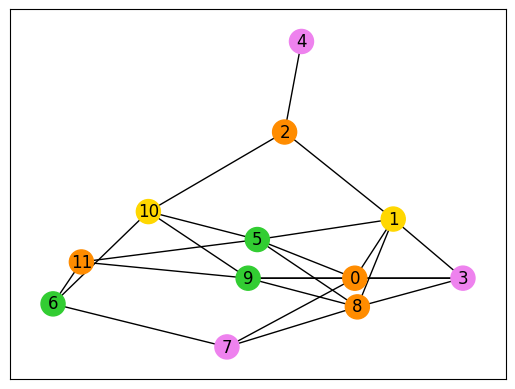

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# get sampleset
sampleset = response.get_sampleset()
# extract feasible solutions
feasible_samples = sampleset.feasibles()
# get the values of feasible objective function
feasible_objectives = [sample.eval.objective for sample in feasible_samples]

if len(feasible_objectives) == 0:
    print('No feasible solution found ...')
else:
    # get the lowest value of objective function
    lowest_index = np.argmin(feasible_objectives)
    # show the value of lowest objective function
    print("Objective: ", feasible_objectives[lowest_index])
    # get indices of x == 1
    indices = sorted(feasible_samples[lowest_index].var_values['x'].values.keys())
    # initialize vertex color list
    node_colors = [-1] * len(indices)
    # set color list for visualization
    colorlist = ['gold', 'violet', 'limegreen', 'darkorange']
    # set vertex color list
    for i, j in indices:
        node_colors[i] = colorlist[j]
    # make figure
    nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
    plt.show()